# Prediction of Diabetic Retinopathy with Deep Learning Algorithms


### CSE3042 - Machine Intelligence for Medical Image Analysis


In [1]:
matrix
import tensorflow as tf
from time import perf_counter
import seaborn as snsimport numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,gaussian_filtered_images\gaussian_filtered_ima...,Mild
1,gaussian_filtered_images\gaussian_filtered_ima...,No_DR
2,gaussian_filtered_images\gaussian_filtered_ima...,No_DR


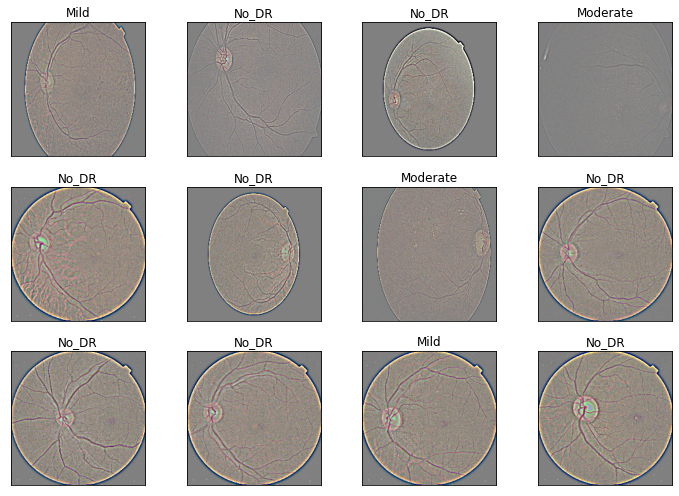

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

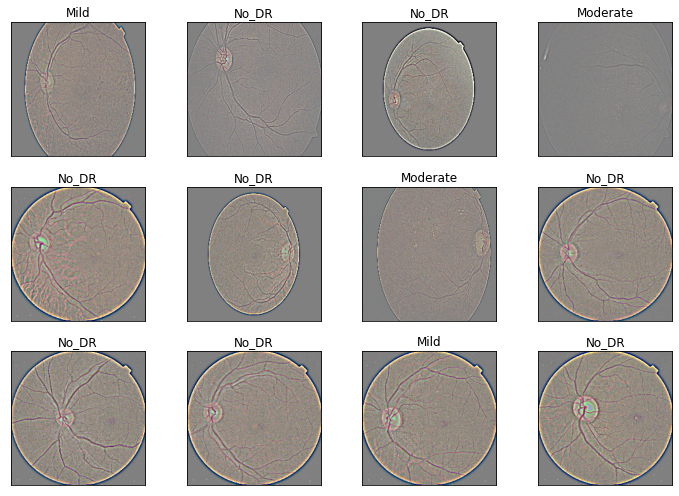

In [5]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

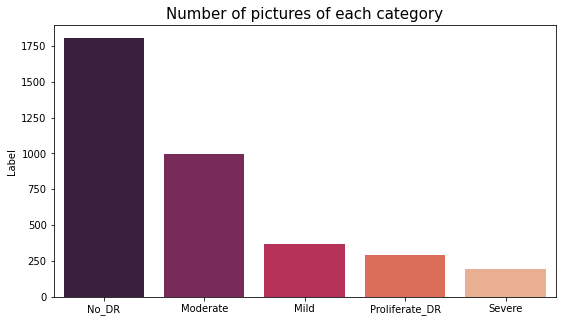

In [6]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()


In [7]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [8]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 174s 2s/step - loss: 0.8611 - accuracy: 0.6989 - val_loss: 0.6858 - val_accuracy: 0.7690
DenseNet121          trained in 174.66 sec
93/93 [==============================] - 45s 456ms/step - loss: 0.7801 - accuracy: 0.7235 - val_loss: 0.7342 - val_accuracy: 0.7568
MobileNetV2          trained in 45.24 sec
93/93 [==============================] - 192s 2s/step - loss: 0.7972 - accuracy: 0.7134 - val_loss: 0.7232 - val_accuracy: 0.6930
DenseNet169          trained in 192.56 sec
93/93 [==============================] - 251s 3s/step - loss: 0.8232 - accuracy: 0.7063 - val_loss: 0.7509 - val_accuracy: 0.7264
DenseNet201          trained in 251.55 sec
93/93 [==============================] - 80s 803ms/step - loss: 1.3185 - accuracy: 0.4724 - val_loss: 1.2466 - val_accuracy:

In [11]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,InceptionResNetV2,0.7050,0.7720,186.63
1,DenseNet121,0.6989,0.7690,174.66
2,ResNet50V2,0.7242,0.7629,106.82
3,ResNet101V2,0.7178,0.7629,209.58
4,MobileNetV2,0.7235,0.7568,45.24
5,ResNet152V2,0.7175,0.7538,312.44
6,NASNetMobile,0.6932,0.7538,76.74
7,MobileNet,0.7097,0.7508,35.43
8,InceptionV3,0.7020,0.7477,76.75
9,Xception,0.6996,0.7447,130.39
